# Data Challenge - Coronavirus Date Study
## load libraries and data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline

In [2]:
df_confirm = pd.read_csv('datasets/time_series_covid_19_confirmed_US.csv')
df_death = pd.read_csv('datasets/time_series_covid_19_deaths_US.csv')

# clean data
 - UID 
 - State information
 - Dates

In [3]:
# extract 'UID', 'Province State', 'Date' from df_confirm
date_start_idx_confirm = df_confirm.columns.get_loc('1/22/20')
dates_confirm = df_confirm.columns[date_start_idx_confirm:-1]
df_confirm_new = df_confirm[['UID', 'Province_State'] +list(dates_confirm)]

# extract 'UID', 'Province State', 'Date', 'Population' from df_death
date_start_idx_death = df_death.columns.get_loc('1/22/20')
dates_death = df_death.columns[date_start_idx_death:-1]
df_death_new = df_death[['UID', 'Province_State','Population'] +list(dates_death)]

# rearrange the dataframe
 - put the date as one column feature, instead of multiple column records
 - put the corresponding confirm and death case with date
 - merge confirm and death dataframes together

In [4]:
# rearrange the df_confirm 
df_confirm_new = df_confirm_new.melt(id_vars=['UID', 'Province_State'],
                   var_name = 'Date', value_name ='Confirm').set_index('UID')

# rearrange the df_death
df_death_new = df_death_new.melt(id_vars=['UID', 'Province_State','Population'],
                   var_name = 'Date', value_name ='Death').set_index('UID')


df_total = df_confirm_new.merge(df_death_new, how='left', on=['UID', 'Date','Province_State'])
# change the object str to datetime dtype
df_total['Date'] = pd.to_datetime(df_total['Date'])


# sum_table
df_new = pd.DataFrame(df_total.groupby(['Date'])['Confirm'].sum())
df_new = df_new.set_index(pd.to_datetime(df_new.index))
df_new['Confirm_diff'] = df_new['Confirm'].diff()
df_new['Death'] = df_total.groupby(['Date'])['Death'].sum()
df_new['Death_diff'] = df_new['Death'].diff()

# Total Cases in USA 
 - Time course trajactory of confirmed case
 - Time course trajactory of death case

In [5]:
def div_two(df):
    return df['Death'].sum() / df['Confirm'].sum()

/Users/yiruichen/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


[Text(0, 0.5, 'Death Rate'), Text(0.5, 0, 'Confirm')]

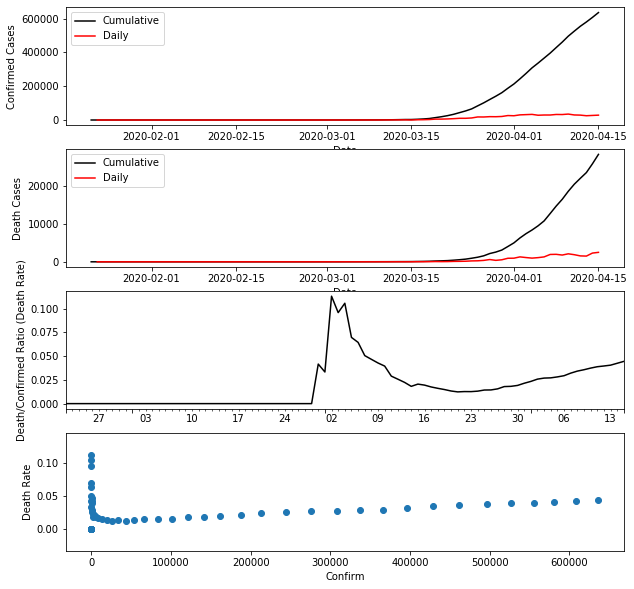

In [6]:
# Create figure and plot space
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows = 4, figsize=(10, 10))
#df_total.groupby(['Date'])['Confirm'].sum().plot(c ='black', ax = ax0, label ='Cumulative')
ax0.plot(df_new.index.values, df_new['Confirm'], c = 'black', label = 'Cumulative')
ax0.plot(df_new.index.values, df_new['Confirm_diff'], c = 'red', label ='Daily')
#df_total.groupby(['Date'])['Death'].sum().plot(c ='black', ax = ax1,label ='Cumulative')
ax1.plot(df_new.index.values, df_new['Death'], c = 'black', label = 'Cumulative')
ax1.plot(df_new.index.values, df_new['Death_diff'], c = 'red', label = 'Daily')
df_total.groupby(['Date']).apply(div_two).plot(c ='black', ax = ax2)
ax3.scatter(df_new['Confirm'], df_total.groupby(['Date']).apply(div_two))
ax0.set(xlabel="Date",ylabel="Confirmed Cases")
ax0.legend()
ax1.set(xlabel="Date",ylabel="Death Cases")
ax1.legend()
ax2.set(xlabel="Date",ylabel ='Death/Confirmed Ratio (Death Rate)')
ax3.set(xlabel ='Confirm', ylabel = 'Death Rate')

# Zoom in spreading region

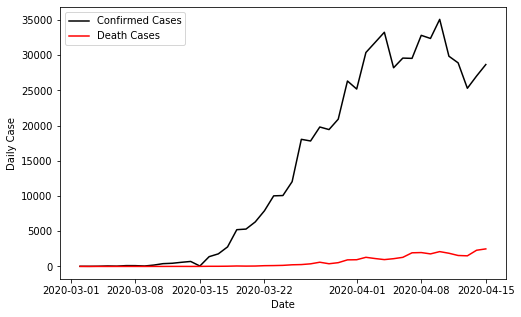

In [7]:
# Date starting from March 1st
index_mask = pd.to_datetime(df_new.index.values) > '2020-03-01'
# plot figure
fig, ax0 = plt.subplots( figsize=(8, 5))
ax0.plot(df_new[index_mask]['Confirm_diff'], c = 'black', label ='Confirmed Cases')
ax0.plot(df_new[index_mask]['Death_diff'], c = 'red', label = 'Death Cases')
ax0.set_xlabel('Date')
ax0.set_ylabel('Daily Case')
ax0.legend()

# Time course based on country regions
 - To see whether nearby states affect each others

In [8]:
# sum table based on date and states
df_new_state = pd.DataFrame(df_total.groupby(['Date','Province_State'])['Confirm'].sum())
df_new_state['Death'] = df_total.groupby(['Date','Province_State'])['Death'].sum()
df_new_state['Population'] = df_total.groupby(['Date','Province_State'])['Population'].sum()

In [9]:
# function that sum all info based on alliance states
def alliance_states(df_new_state, states):
    dic ={}
    for idx, state in enumerate(states):
        df_new_ = df_new_state.loc(axis=0)[pd.IndexSlice[:,[state]]]
        df_new_['Confirm_diff'] = df_new_['Confirm'].diff()
        min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
        df_new_scaled = min_max_scaler.fit_transform(df_new_)
        dic[state] = [df_new_.index.get_level_values('Date'), df_new_scaled[:,-1]]
    return dic

In [ ]:
# Normalized time course of daily confirmation cased on different states
state_dic ={"Pacific States": ["Washington", "Oregon", "California"],
           "NorthEast States_1": ["Connecticut", "Massachusetts", "New Jersey", "New York", "Pennsylvania"],
           "NorthEast States_2": ["District of Columbia", "Virginia", "Maryland"],
           "Lake States":["Indiana", "Michigan", "Ohio", "Illinois"],
           "Southern States": ["Georgia", "Florida", "Texas", "Louisiana"]}

n_rows = len(state_dic)
fig, ax = plt.subplots(nrows = len(state_dic), figsize = (10, 10))
i = 0
for key, states in state_dic.items():
    states_data = alliance_states(df_new_state, states)
    for state in states_data:
        ax[i].plot(states_data[state][0], states_data[state][1], label = state)
    ax[i].set_prop_cycle
    ax[i].legend()
    i += 1

/Users/yiruichen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/yiruichen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/yiruichen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

# Does Population matter?

In [ ]:
# Add confirm case based on population - normalized the data
df_new_state['ConfirmVSPopulation'] = df_new_state['Confirm']/df_new_state['Population']
# only observe when pandamic occurs
dff = df_new_state[df_new_state.index.get_level_values(0) >= '2020-03-20']

In [ ]:
# generate pivot table and heatmap
df_new_state_pivot = dff.pivot_table(index = "Date", columns = "Population", values = "ConfirmVSPopulation")
sns.heatmap(df_new_state_pivot,vmin=0, vmax=0.01)